# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

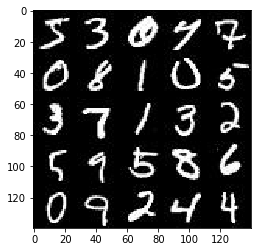

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

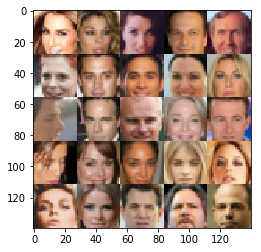

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    # keep_prob = 0.9
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flatten = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.01
    # keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 14x14x256
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 28x28x128
        # 14x14x128

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', activation=None)             
        output = tf.tanh(logits)        
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(g_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=disc_logits_real,
                            labels=tf.ones_like(disc_output_real) * (1-smooth)
                        )
                     )
    
    disc_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=disc_logits_fake,
                            labels=tf.zeros_like(disc_output_fake)
                        )
                     )
    
    gen_loss = tf.reduce_mean(
                   tf.nn.sigmoid_cross_entropy_with_logits(
                       logits=disc_logits_fake,
                       labels=tf.ones_like(disc_output_fake)
                    )
                )
    
    disc_loss = disc_loss_real + disc_loss_fake       
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                               beta1=beta1).minimize(g_loss,
                                                                     var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                                beta1=beta1).minimize(d_loss,
                                                                      var_list=disc_vars)
    
    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(disc_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    lr: learning_rate
                })
                
                _ = sess.run(gen_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    lr: learning_rate
                })
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    train_loss_d = disc_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    train_loss_g = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                           "Batch {}...".format(steps),
                           "Generator Loss: {:.4f}".format(train_loss_g),
                           "Discriminator Loss: {:.4f}".format(train_loss_d))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
         
        saver.save(sess, './generator.ckpt')
        
    return losses
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


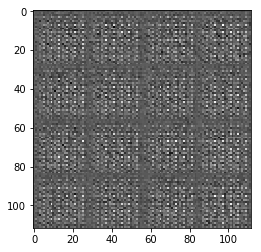

Epoch 1/2... Batch 10... Generator Loss: 3.3083 Discriminator Loss: 1.2627
Epoch 1/2... Batch 20... Generator Loss: 3.3910 Discriminator Loss: 0.4797
Epoch 1/2... Batch 30... Generator Loss: 4.1976 Discriminator Loss: 0.4301
Epoch 1/2... Batch 40... Generator Loss: 4.1085 Discriminator Loss: 0.3950
Epoch 1/2... Batch 50... Generator Loss: 3.5406 Discriminator Loss: 0.3857
Epoch 1/2... Batch 60... Generator Loss: 3.0417 Discriminator Loss: 0.6090
Epoch 1/2... Batch 70... Generator Loss: 5.1965 Discriminator Loss: 0.3912
Epoch 1/2... Batch 80... Generator Loss: 3.2193 Discriminator Loss: 0.4006
Epoch 1/2... Batch 90... Generator Loss: 3.6009 Discriminator Loss: 0.3768
Epoch 1/2... Batch 100... Generator Loss: 3.8493 Discriminator Loss: 0.3988


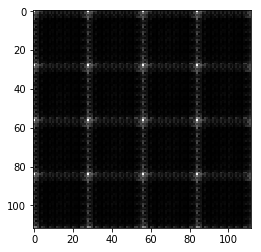

Epoch 1/2... Batch 110... Generator Loss: 4.1121 Discriminator Loss: 0.3706
Epoch 1/2... Batch 120... Generator Loss: 3.2309 Discriminator Loss: 0.4748
Epoch 1/2... Batch 130... Generator Loss: 2.8436 Discriminator Loss: 0.9047
Epoch 1/2... Batch 140... Generator Loss: 1.5839 Discriminator Loss: 0.6990
Epoch 1/2... Batch 150... Generator Loss: 2.5307 Discriminator Loss: 0.5795
Epoch 1/2... Batch 160... Generator Loss: 1.1806 Discriminator Loss: 0.8515
Epoch 1/2... Batch 170... Generator Loss: 0.7813 Discriminator Loss: 1.3343
Epoch 1/2... Batch 180... Generator Loss: 2.2456 Discriminator Loss: 0.6817
Epoch 1/2... Batch 190... Generator Loss: 3.0618 Discriminator Loss: 1.0625
Epoch 1/2... Batch 200... Generator Loss: 1.5686 Discriminator Loss: 0.6678


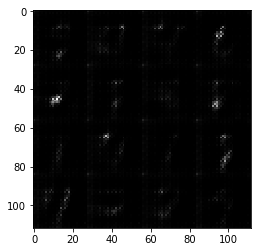

Epoch 1/2... Batch 210... Generator Loss: 1.8085 Discriminator Loss: 0.7518
Epoch 1/2... Batch 220... Generator Loss: 1.3453 Discriminator Loss: 0.8223
Epoch 1/2... Batch 230... Generator Loss: 2.2550 Discriminator Loss: 0.7803
Epoch 1/2... Batch 240... Generator Loss: 1.7540 Discriminator Loss: 0.8878
Epoch 1/2... Batch 250... Generator Loss: 1.5687 Discriminator Loss: 0.7866
Epoch 1/2... Batch 260... Generator Loss: 0.6301 Discriminator Loss: 1.2524
Epoch 1/2... Batch 270... Generator Loss: 1.4258 Discriminator Loss: 0.8155
Epoch 1/2... Batch 280... Generator Loss: 1.2406 Discriminator Loss: 0.9244
Epoch 1/2... Batch 290... Generator Loss: 0.6310 Discriminator Loss: 1.2594
Epoch 1/2... Batch 300... Generator Loss: 1.4231 Discriminator Loss: 0.8497


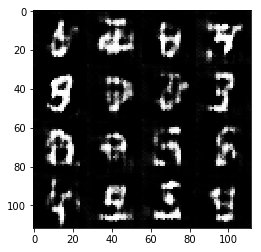

Epoch 1/2... Batch 310... Generator Loss: 2.1766 Discriminator Loss: 1.0943
Epoch 1/2... Batch 320... Generator Loss: 1.1167 Discriminator Loss: 0.9912
Epoch 1/2... Batch 330... Generator Loss: 1.7517 Discriminator Loss: 0.9103
Epoch 1/2... Batch 340... Generator Loss: 1.1565 Discriminator Loss: 0.9375
Epoch 1/2... Batch 350... Generator Loss: 1.9959 Discriminator Loss: 1.0010
Epoch 1/2... Batch 360... Generator Loss: 1.2706 Discriminator Loss: 0.9142
Epoch 1/2... Batch 370... Generator Loss: 0.6293 Discriminator Loss: 1.2711
Epoch 1/2... Batch 380... Generator Loss: 1.0533 Discriminator Loss: 0.9928
Epoch 1/2... Batch 390... Generator Loss: 1.4554 Discriminator Loss: 0.9366
Epoch 1/2... Batch 400... Generator Loss: 0.7128 Discriminator Loss: 1.1942


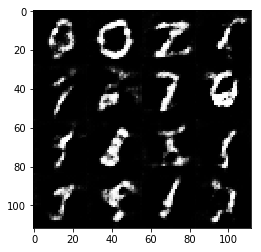

Epoch 1/2... Batch 410... Generator Loss: 1.1288 Discriminator Loss: 1.0339
Epoch 1/2... Batch 420... Generator Loss: 1.4629 Discriminator Loss: 0.8694
Epoch 1/2... Batch 430... Generator Loss: 0.8603 Discriminator Loss: 1.1314
Epoch 1/2... Batch 440... Generator Loss: 1.3822 Discriminator Loss: 0.8371
Epoch 1/2... Batch 450... Generator Loss: 1.1397 Discriminator Loss: 0.9438
Epoch 1/2... Batch 460... Generator Loss: 0.7587 Discriminator Loss: 1.2187
Epoch 1/2... Batch 470... Generator Loss: 1.0054 Discriminator Loss: 0.9863
Epoch 1/2... Batch 480... Generator Loss: 0.8185 Discriminator Loss: 1.0972
Epoch 1/2... Batch 490... Generator Loss: 1.2689 Discriminator Loss: 0.9975
Epoch 1/2... Batch 500... Generator Loss: 1.2129 Discriminator Loss: 0.9104


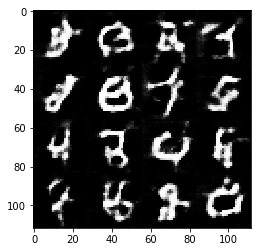

Epoch 1/2... Batch 510... Generator Loss: 0.7787 Discriminator Loss: 1.1504
Epoch 1/2... Batch 520... Generator Loss: 1.2876 Discriminator Loss: 0.9954
Epoch 1/2... Batch 530... Generator Loss: 2.5022 Discriminator Loss: 1.2840
Epoch 1/2... Batch 540... Generator Loss: 0.7848 Discriminator Loss: 1.1662
Epoch 1/2... Batch 550... Generator Loss: 0.6054 Discriminator Loss: 1.2354
Epoch 1/2... Batch 560... Generator Loss: 0.9473 Discriminator Loss: 1.0343
Epoch 1/2... Batch 570... Generator Loss: 0.7399 Discriminator Loss: 1.2192
Epoch 1/2... Batch 580... Generator Loss: 1.0971 Discriminator Loss: 0.9638
Epoch 1/2... Batch 590... Generator Loss: 1.0473 Discriminator Loss: 0.9492
Epoch 1/2... Batch 600... Generator Loss: 1.5751 Discriminator Loss: 0.9099


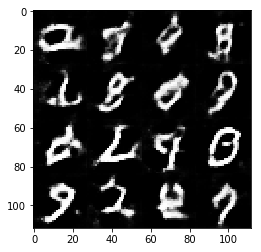

Epoch 1/2... Batch 610... Generator Loss: 1.4832 Discriminator Loss: 0.9630
Epoch 1/2... Batch 620... Generator Loss: 1.3784 Discriminator Loss: 0.9220
Epoch 1/2... Batch 630... Generator Loss: 0.7736 Discriminator Loss: 1.1326
Epoch 1/2... Batch 640... Generator Loss: 1.5579 Discriminator Loss: 0.9535
Epoch 1/2... Batch 650... Generator Loss: 1.6759 Discriminator Loss: 1.1112
Epoch 1/2... Batch 660... Generator Loss: 0.9434 Discriminator Loss: 1.0205
Epoch 1/2... Batch 670... Generator Loss: 1.3537 Discriminator Loss: 0.9204
Epoch 1/2... Batch 680... Generator Loss: 0.9196 Discriminator Loss: 1.1066
Epoch 1/2... Batch 690... Generator Loss: 1.0515 Discriminator Loss: 0.9447
Epoch 1/2... Batch 700... Generator Loss: 1.9047 Discriminator Loss: 1.1406


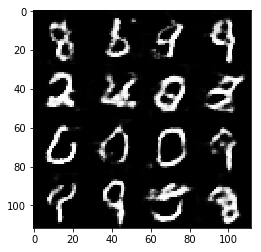

Epoch 1/2... Batch 710... Generator Loss: 0.8013 Discriminator Loss: 1.1301
Epoch 1/2... Batch 720... Generator Loss: 0.5917 Discriminator Loss: 1.2853
Epoch 1/2... Batch 730... Generator Loss: 1.2941 Discriminator Loss: 0.9653
Epoch 1/2... Batch 740... Generator Loss: 1.2789 Discriminator Loss: 0.8931
Epoch 1/2... Batch 750... Generator Loss: 0.7276 Discriminator Loss: 1.1450
Epoch 1/2... Batch 760... Generator Loss: 0.8515 Discriminator Loss: 1.0425
Epoch 1/2... Batch 770... Generator Loss: 1.1060 Discriminator Loss: 0.9080
Epoch 1/2... Batch 780... Generator Loss: 0.5667 Discriminator Loss: 1.3997
Epoch 1/2... Batch 790... Generator Loss: 1.3350 Discriminator Loss: 0.9058
Epoch 1/2... Batch 800... Generator Loss: 0.8974 Discriminator Loss: 1.0293


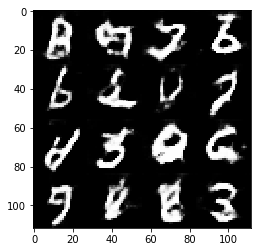

Epoch 1/2... Batch 810... Generator Loss: 1.1226 Discriminator Loss: 0.8819
Epoch 1/2... Batch 820... Generator Loss: 1.3787 Discriminator Loss: 0.9221
Epoch 1/2... Batch 830... Generator Loss: 1.5877 Discriminator Loss: 0.8909
Epoch 1/2... Batch 840... Generator Loss: 1.7906 Discriminator Loss: 0.6755
Epoch 1/2... Batch 850... Generator Loss: 1.6825 Discriminator Loss: 0.7157
Epoch 1/2... Batch 860... Generator Loss: 0.6105 Discriminator Loss: 1.5098
Epoch 1/2... Batch 870... Generator Loss: 0.9312 Discriminator Loss: 1.0576
Epoch 1/2... Batch 880... Generator Loss: 0.7565 Discriminator Loss: 1.1344
Epoch 1/2... Batch 890... Generator Loss: 1.3237 Discriminator Loss: 0.8920
Epoch 1/2... Batch 900... Generator Loss: 1.7537 Discriminator Loss: 0.9259


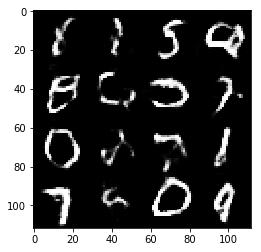

Epoch 1/2... Batch 910... Generator Loss: 0.8302 Discriminator Loss: 1.0507
Epoch 1/2... Batch 920... Generator Loss: 1.1822 Discriminator Loss: 0.8880
Epoch 1/2... Batch 930... Generator Loss: 0.5361 Discriminator Loss: 1.4240
Epoch 2/2... Batch 940... Generator Loss: 0.9203 Discriminator Loss: 1.0071
Epoch 2/2... Batch 950... Generator Loss: 1.1203 Discriminator Loss: 0.8647
Epoch 2/2... Batch 960... Generator Loss: 1.0349 Discriminator Loss: 0.9162
Epoch 2/2... Batch 970... Generator Loss: 0.8841 Discriminator Loss: 1.0341
Epoch 2/2... Batch 980... Generator Loss: 0.5757 Discriminator Loss: 1.3169
Epoch 2/2... Batch 990... Generator Loss: 1.8895 Discriminator Loss: 0.8104
Epoch 2/2... Batch 1000... Generator Loss: 1.6406 Discriminator Loss: 0.8590


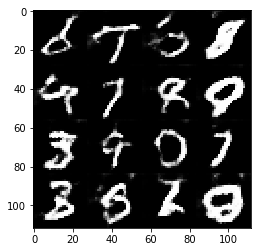

Epoch 2/2... Batch 1010... Generator Loss: 1.4453 Discriminator Loss: 0.8176
Epoch 2/2... Batch 1020... Generator Loss: 1.1492 Discriminator Loss: 0.9052
Epoch 2/2... Batch 1030... Generator Loss: 1.4011 Discriminator Loss: 0.7700
Epoch 2/2... Batch 1040... Generator Loss: 1.1267 Discriminator Loss: 0.9313
Epoch 2/2... Batch 1050... Generator Loss: 1.6408 Discriminator Loss: 0.7077
Epoch 2/2... Batch 1060... Generator Loss: 0.4148 Discriminator Loss: 1.6670
Epoch 2/2... Batch 1070... Generator Loss: 1.4342 Discriminator Loss: 0.8703
Epoch 2/2... Batch 1080... Generator Loss: 1.0878 Discriminator Loss: 0.8913
Epoch 2/2... Batch 1090... Generator Loss: 1.3524 Discriminator Loss: 0.7885
Epoch 2/2... Batch 1100... Generator Loss: 0.7767 Discriminator Loss: 1.0772


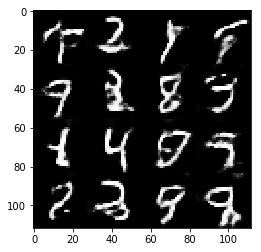

Epoch 2/2... Batch 1110... Generator Loss: 1.2945 Discriminator Loss: 0.8534
Epoch 2/2... Batch 1120... Generator Loss: 1.5375 Discriminator Loss: 0.7291
Epoch 2/2... Batch 1130... Generator Loss: 1.4306 Discriminator Loss: 0.8317
Epoch 2/2... Batch 1140... Generator Loss: 1.1928 Discriminator Loss: 0.8187
Epoch 2/2... Batch 1150... Generator Loss: 0.9162 Discriminator Loss: 1.0297
Epoch 2/2... Batch 1160... Generator Loss: 0.7875 Discriminator Loss: 1.1934
Epoch 2/2... Batch 1170... Generator Loss: 0.7412 Discriminator Loss: 1.1303
Epoch 2/2... Batch 1180... Generator Loss: 0.8636 Discriminator Loss: 0.9840
Epoch 2/2... Batch 1190... Generator Loss: 0.4707 Discriminator Loss: 1.5630
Epoch 2/2... Batch 1200... Generator Loss: 1.2064 Discriminator Loss: 0.8214


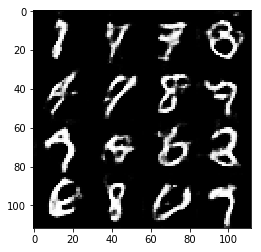

Epoch 2/2... Batch 1210... Generator Loss: 1.3556 Discriminator Loss: 0.8180
Epoch 2/2... Batch 1220... Generator Loss: 0.9292 Discriminator Loss: 0.9551
Epoch 2/2... Batch 1230... Generator Loss: 1.3111 Discriminator Loss: 0.8475
Epoch 2/2... Batch 1240... Generator Loss: 1.8822 Discriminator Loss: 0.8813
Epoch 2/2... Batch 1250... Generator Loss: 1.0187 Discriminator Loss: 0.9202
Epoch 2/2... Batch 1260... Generator Loss: 1.1452 Discriminator Loss: 0.8459
Epoch 2/2... Batch 1270... Generator Loss: 0.8290 Discriminator Loss: 1.0588
Epoch 2/2... Batch 1280... Generator Loss: 0.7165 Discriminator Loss: 1.1676
Epoch 2/2... Batch 1290... Generator Loss: 1.4489 Discriminator Loss: 0.8615
Epoch 2/2... Batch 1300... Generator Loss: 1.2573 Discriminator Loss: 0.7965


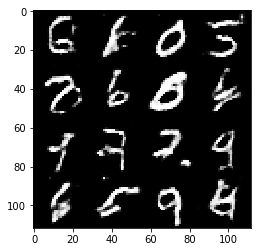

Epoch 2/2... Batch 1310... Generator Loss: 1.1011 Discriminator Loss: 0.8980
Epoch 2/2... Batch 1320... Generator Loss: 1.3138 Discriminator Loss: 0.8823
Epoch 2/2... Batch 1330... Generator Loss: 1.5049 Discriminator Loss: 0.7457
Epoch 2/2... Batch 1340... Generator Loss: 1.4626 Discriminator Loss: 0.7242
Epoch 2/2... Batch 1350... Generator Loss: 0.1819 Discriminator Loss: 2.4458
Epoch 2/2... Batch 1360... Generator Loss: 1.2226 Discriminator Loss: 1.1174
Epoch 2/2... Batch 1370... Generator Loss: 1.7698 Discriminator Loss: 0.9398
Epoch 2/2... Batch 1380... Generator Loss: 1.1087 Discriminator Loss: 0.8721
Epoch 2/2... Batch 1390... Generator Loss: 1.6324 Discriminator Loss: 0.7314
Epoch 2/2... Batch 1400... Generator Loss: 1.6914 Discriminator Loss: 0.7735


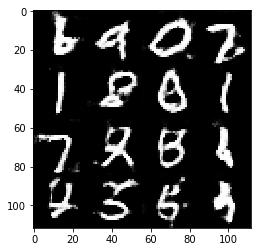

Epoch 2/2... Batch 1410... Generator Loss: 0.6247 Discriminator Loss: 1.2702
Epoch 2/2... Batch 1420... Generator Loss: 1.2178 Discriminator Loss: 0.8619
Epoch 2/2... Batch 1430... Generator Loss: 0.8037 Discriminator Loss: 1.0430
Epoch 2/2... Batch 1440... Generator Loss: 1.7636 Discriminator Loss: 0.6735
Epoch 2/2... Batch 1450... Generator Loss: 0.9857 Discriminator Loss: 0.9757
Epoch 2/2... Batch 1460... Generator Loss: 1.8339 Discriminator Loss: 0.7131
Epoch 2/2... Batch 1470... Generator Loss: 1.2065 Discriminator Loss: 0.7754
Epoch 2/2... Batch 1480... Generator Loss: 1.4938 Discriminator Loss: 0.7234
Epoch 2/2... Batch 1490... Generator Loss: 0.8072 Discriminator Loss: 1.0528
Epoch 2/2... Batch 1500... Generator Loss: 1.7683 Discriminator Loss: 0.6564


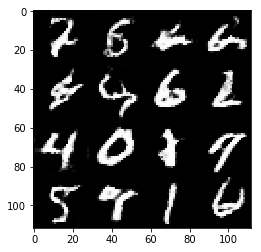

Epoch 2/2... Batch 1510... Generator Loss: 0.8899 Discriminator Loss: 0.9951
Epoch 2/2... Batch 1520... Generator Loss: 1.2967 Discriminator Loss: 0.7694
Epoch 2/2... Batch 1530... Generator Loss: 1.4226 Discriminator Loss: 0.7374
Epoch 2/2... Batch 1540... Generator Loss: 1.4080 Discriminator Loss: 0.7450
Epoch 2/2... Batch 1550... Generator Loss: 0.9883 Discriminator Loss: 0.9136
Epoch 2/2... Batch 1560... Generator Loss: 1.9931 Discriminator Loss: 0.7324
Epoch 2/2... Batch 1570... Generator Loss: 0.6690 Discriminator Loss: 1.2149
Epoch 2/2... Batch 1580... Generator Loss: 1.5494 Discriminator Loss: 0.6628
Epoch 2/2... Batch 1590... Generator Loss: 0.5119 Discriminator Loss: 1.3984
Epoch 2/2... Batch 1600... Generator Loss: 0.8264 Discriminator Loss: 1.0809


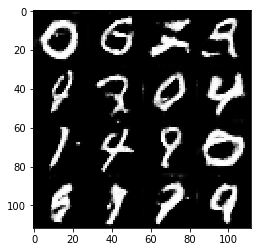

Epoch 2/2... Batch 1610... Generator Loss: 1.7059 Discriminator Loss: 0.9435
Epoch 2/2... Batch 1620... Generator Loss: 1.8774 Discriminator Loss: 0.6988
Epoch 2/2... Batch 1630... Generator Loss: 0.9478 Discriminator Loss: 0.9663
Epoch 2/2... Batch 1640... Generator Loss: 1.0638 Discriminator Loss: 0.9132
Epoch 2/2... Batch 1650... Generator Loss: 1.7537 Discriminator Loss: 0.6340
Epoch 2/2... Batch 1660... Generator Loss: 2.3764 Discriminator Loss: 0.9456
Epoch 2/2... Batch 1670... Generator Loss: 1.7772 Discriminator Loss: 0.7405
Epoch 2/2... Batch 1680... Generator Loss: 1.8320 Discriminator Loss: 0.6774
Epoch 2/2... Batch 1690... Generator Loss: 1.3941 Discriminator Loss: 0.7266
Epoch 2/2... Batch 1700... Generator Loss: 0.9018 Discriminator Loss: 0.9671


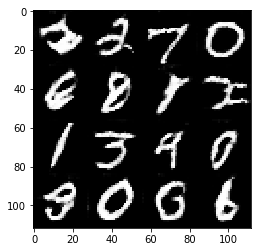

Epoch 2/2... Batch 1710... Generator Loss: 1.7016 Discriminator Loss: 0.6916
Epoch 2/2... Batch 1720... Generator Loss: 0.6529 Discriminator Loss: 1.3021
Epoch 2/2... Batch 1730... Generator Loss: 0.5114 Discriminator Loss: 1.4764
Epoch 2/2... Batch 1740... Generator Loss: 1.1576 Discriminator Loss: 0.8048
Epoch 2/2... Batch 1750... Generator Loss: 1.5919 Discriminator Loss: 0.7154
Epoch 2/2... Batch 1760... Generator Loss: 1.8875 Discriminator Loss: 0.6835
Epoch 2/2... Batch 1770... Generator Loss: 1.8409 Discriminator Loss: 0.7305
Epoch 2/2... Batch 1780... Generator Loss: 0.9573 Discriminator Loss: 0.9902
Epoch 2/2... Batch 1790... Generator Loss: 1.6683 Discriminator Loss: 0.6155
Epoch 2/2... Batch 1800... Generator Loss: 0.7843 Discriminator Loss: 1.1057


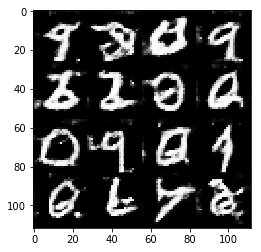

Epoch 2/2... Batch 1810... Generator Loss: 1.2510 Discriminator Loss: 0.8184
Epoch 2/2... Batch 1820... Generator Loss: 0.7862 Discriminator Loss: 1.0704
Epoch 2/2... Batch 1830... Generator Loss: 1.6965 Discriminator Loss: 0.6832
Epoch 2/2... Batch 1840... Generator Loss: 1.1148 Discriminator Loss: 0.8717
Epoch 2/2... Batch 1850... Generator Loss: 1.1520 Discriminator Loss: 0.8235
Epoch 2/2... Batch 1860... Generator Loss: 1.1439 Discriminator Loss: 0.8074
Epoch 2/2... Batch 1870... Generator Loss: 1.3917 Discriminator Loss: 0.7107


In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


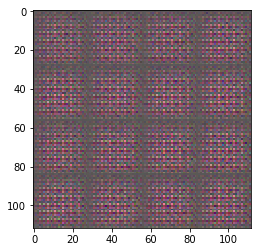

Epoch 1/1... Batch 10... Generator Loss: 1.3997 Discriminator Loss: 0.9062
Epoch 1/1... Batch 20... Generator Loss: 6.4745 Discriminator Loss: 0.4916
Epoch 1/1... Batch 30... Generator Loss: 0.0435 Discriminator Loss: 3.7337
Epoch 1/1... Batch 40... Generator Loss: 1.3554 Discriminator Loss: 0.8470
Epoch 1/1... Batch 50... Generator Loss: 3.3583 Discriminator Loss: 0.7555
Epoch 1/1... Batch 60... Generator Loss: 3.4249 Discriminator Loss: 0.9295
Epoch 1/1... Batch 70... Generator Loss: 1.5710 Discriminator Loss: 0.8784
Epoch 1/1... Batch 80... Generator Loss: 0.6808 Discriminator Loss: 1.4304
Epoch 1/1... Batch 90... Generator Loss: 1.3824 Discriminator Loss: 1.0052
Epoch 1/1... Batch 100... Generator Loss: 0.7294 Discriminator Loss: 1.2464


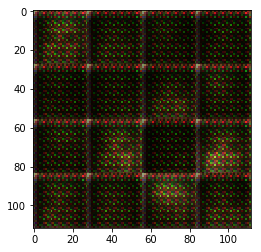

Epoch 1/1... Batch 110... Generator Loss: 0.9198 Discriminator Loss: 1.1369
Epoch 1/1... Batch 120... Generator Loss: 2.0353 Discriminator Loss: 1.1561
Epoch 1/1... Batch 130... Generator Loss: 0.6348 Discriminator Loss: 1.5583
Epoch 1/1... Batch 140... Generator Loss: 0.9559 Discriminator Loss: 1.3123
Epoch 1/1... Batch 150... Generator Loss: 2.2605 Discriminator Loss: 1.1404
Epoch 1/1... Batch 160... Generator Loss: 1.2031 Discriminator Loss: 1.4379
Epoch 1/1... Batch 170... Generator Loss: 2.1939 Discriminator Loss: 1.3733
Epoch 1/1... Batch 180... Generator Loss: 1.5330 Discriminator Loss: 1.0485
Epoch 1/1... Batch 190... Generator Loss: 0.9769 Discriminator Loss: 1.1873
Epoch 1/1... Batch 200... Generator Loss: 1.2064 Discriminator Loss: 1.1508


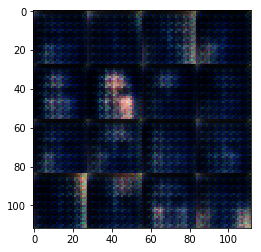

Epoch 1/1... Batch 210... Generator Loss: 3.3089 Discriminator Loss: 1.7519
Epoch 1/1... Batch 220... Generator Loss: 1.0615 Discriminator Loss: 1.0637
Epoch 1/1... Batch 230... Generator Loss: 1.0637 Discriminator Loss: 1.0192
Epoch 1/1... Batch 240... Generator Loss: 1.0479 Discriminator Loss: 1.3764
Epoch 1/1... Batch 250... Generator Loss: 1.8651 Discriminator Loss: 1.0107
Epoch 1/1... Batch 260... Generator Loss: 1.1303 Discriminator Loss: 1.3618
Epoch 1/1... Batch 270... Generator Loss: 0.6854 Discriminator Loss: 1.3503
Epoch 1/1... Batch 280... Generator Loss: 1.1960 Discriminator Loss: 1.3139
Epoch 1/1... Batch 290... Generator Loss: 0.7106 Discriminator Loss: 1.3251
Epoch 1/1... Batch 300... Generator Loss: 1.0212 Discriminator Loss: 1.1454


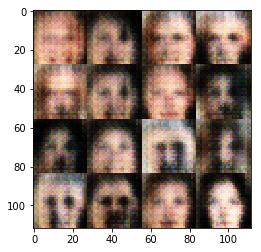

Epoch 1/1... Batch 310... Generator Loss: 0.8528 Discriminator Loss: 1.3205
Epoch 1/1... Batch 320... Generator Loss: 1.1765 Discriminator Loss: 1.3574
Epoch 1/1... Batch 330... Generator Loss: 1.1421 Discriminator Loss: 1.2166
Epoch 1/1... Batch 340... Generator Loss: 0.9990 Discriminator Loss: 1.0890
Epoch 1/1... Batch 350... Generator Loss: 0.7975 Discriminator Loss: 1.5031
Epoch 1/1... Batch 360... Generator Loss: 0.9425 Discriminator Loss: 1.3511
Epoch 1/1... Batch 370... Generator Loss: 0.9560 Discriminator Loss: 1.1309
Epoch 1/1... Batch 380... Generator Loss: 1.0752 Discriminator Loss: 1.0948
Epoch 1/1... Batch 390... Generator Loss: 1.9800 Discriminator Loss: 1.2475
Epoch 1/1... Batch 400... Generator Loss: 1.4922 Discriminator Loss: 1.0750


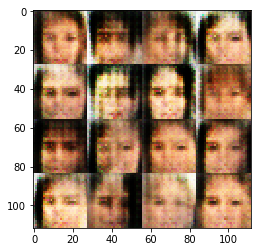

Epoch 1/1... Batch 410... Generator Loss: 0.7846 Discriminator Loss: 1.1513
Epoch 1/1... Batch 420... Generator Loss: 1.2042 Discriminator Loss: 1.2786
Epoch 1/1... Batch 430... Generator Loss: 0.6952 Discriminator Loss: 1.2217
Epoch 1/1... Batch 440... Generator Loss: 1.4491 Discriminator Loss: 1.3197
Epoch 1/1... Batch 450... Generator Loss: 0.5964 Discriminator Loss: 1.3415
Epoch 1/1... Batch 460... Generator Loss: 0.5187 Discriminator Loss: 1.5678
Epoch 1/1... Batch 470... Generator Loss: 0.5118 Discriminator Loss: 1.5356
Epoch 1/1... Batch 480... Generator Loss: 0.5378 Discriminator Loss: 1.5622
Epoch 1/1... Batch 490... Generator Loss: 0.9765 Discriminator Loss: 1.2471
Epoch 1/1... Batch 500... Generator Loss: 0.7112 Discriminator Loss: 1.3411


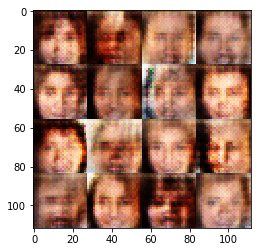

Epoch 1/1... Batch 510... Generator Loss: 0.9282 Discriminator Loss: 1.4074
Epoch 1/1... Batch 520... Generator Loss: 1.3690 Discriminator Loss: 1.2057
Epoch 1/1... Batch 530... Generator Loss: 0.6882 Discriminator Loss: 1.2800
Epoch 1/1... Batch 540... Generator Loss: 1.3528 Discriminator Loss: 1.2526
Epoch 1/1... Batch 550... Generator Loss: 0.8504 Discriminator Loss: 1.3626
Epoch 1/1... Batch 560... Generator Loss: 0.7190 Discriminator Loss: 1.4037
Epoch 1/1... Batch 570... Generator Loss: 1.1456 Discriminator Loss: 1.3672
Epoch 1/1... Batch 580... Generator Loss: 1.1556 Discriminator Loss: 1.0631
Epoch 1/1... Batch 590... Generator Loss: 0.9465 Discriminator Loss: 1.2840
Epoch 1/1... Batch 600... Generator Loss: 1.8407 Discriminator Loss: 1.3005


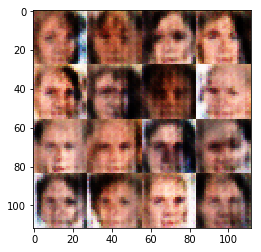

Epoch 1/1... Batch 610... Generator Loss: 0.6004 Discriminator Loss: 1.3648
Epoch 1/1... Batch 620... Generator Loss: 1.0341 Discriminator Loss: 1.1928
Epoch 1/1... Batch 630... Generator Loss: 0.9067 Discriminator Loss: 1.3139
Epoch 1/1... Batch 640... Generator Loss: 0.9014 Discriminator Loss: 1.4114
Epoch 1/1... Batch 650... Generator Loss: 0.9058 Discriminator Loss: 1.1737
Epoch 1/1... Batch 660... Generator Loss: 1.5084 Discriminator Loss: 1.3567
Epoch 1/1... Batch 670... Generator Loss: 1.4465 Discriminator Loss: 1.4034
Epoch 1/1... Batch 680... Generator Loss: 1.0964 Discriminator Loss: 1.5517
Epoch 1/1... Batch 690... Generator Loss: 0.8742 Discriminator Loss: 1.1566
Epoch 1/1... Batch 700... Generator Loss: 1.0495 Discriminator Loss: 1.1825


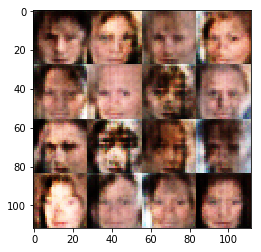

Epoch 1/1... Batch 710... Generator Loss: 0.8801 Discriminator Loss: 1.2929
Epoch 1/1... Batch 720... Generator Loss: 0.7518 Discriminator Loss: 1.3065
Epoch 1/1... Batch 730... Generator Loss: 0.7654 Discriminator Loss: 1.3415
Epoch 1/1... Batch 740... Generator Loss: 1.0183 Discriminator Loss: 1.1406
Epoch 1/1... Batch 750... Generator Loss: 0.8902 Discriminator Loss: 1.2610
Epoch 1/1... Batch 760... Generator Loss: 1.2543 Discriminator Loss: 1.2682
Epoch 1/1... Batch 770... Generator Loss: 1.3571 Discriminator Loss: 1.1748
Epoch 1/1... Batch 780... Generator Loss: 0.8175 Discriminator Loss: 1.1840
Epoch 1/1... Batch 790... Generator Loss: 1.0990 Discriminator Loss: 1.1480
Epoch 1/1... Batch 800... Generator Loss: 0.6139 Discriminator Loss: 1.4335


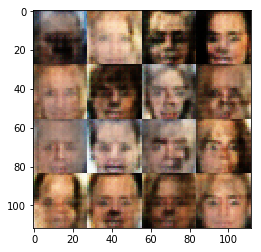

Epoch 1/1... Batch 810... Generator Loss: 0.9951 Discriminator Loss: 1.1880
Epoch 1/1... Batch 820... Generator Loss: 1.0232 Discriminator Loss: 1.1873
Epoch 1/1... Batch 830... Generator Loss: 0.8976 Discriminator Loss: 1.4558
Epoch 1/1... Batch 840... Generator Loss: 0.9140 Discriminator Loss: 1.1876
Epoch 1/1... Batch 850... Generator Loss: 0.8089 Discriminator Loss: 1.2512
Epoch 1/1... Batch 860... Generator Loss: 0.7243 Discriminator Loss: 1.3017
Epoch 1/1... Batch 870... Generator Loss: 0.6853 Discriminator Loss: 1.4789
Epoch 1/1... Batch 880... Generator Loss: 0.8798 Discriminator Loss: 1.2650
Epoch 1/1... Batch 890... Generator Loss: 0.7742 Discriminator Loss: 1.2311
Epoch 1/1... Batch 900... Generator Loss: 0.8231 Discriminator Loss: 1.1798


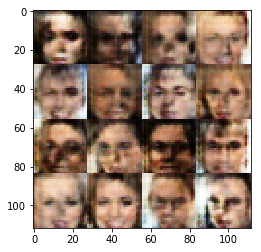

Epoch 1/1... Batch 910... Generator Loss: 0.9760 Discriminator Loss: 1.1933
Epoch 1/1... Batch 920... Generator Loss: 0.9027 Discriminator Loss: 1.2954
Epoch 1/1... Batch 930... Generator Loss: 1.2822 Discriminator Loss: 1.2201
Epoch 1/1... Batch 940... Generator Loss: 1.2184 Discriminator Loss: 1.2044
Epoch 1/1... Batch 950... Generator Loss: 1.2090 Discriminator Loss: 1.3189
Epoch 1/1... Batch 960... Generator Loss: 0.9533 Discriminator Loss: 1.3546
Epoch 1/1... Batch 970... Generator Loss: 0.8556 Discriminator Loss: 1.2905
Epoch 1/1... Batch 980... Generator Loss: 0.8337 Discriminator Loss: 1.1869
Epoch 1/1... Batch 990... Generator Loss: 1.2076 Discriminator Loss: 1.2736
Epoch 1/1... Batch 1000... Generator Loss: 1.0783 Discriminator Loss: 1.3847


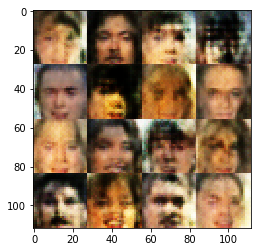

Epoch 1/1... Batch 1010... Generator Loss: 0.9498 Discriminator Loss: 1.2361
Epoch 1/1... Batch 1020... Generator Loss: 0.7447 Discriminator Loss: 1.1955
Epoch 1/1... Batch 1030... Generator Loss: 0.7704 Discriminator Loss: 1.5742
Epoch 1/1... Batch 1040... Generator Loss: 0.7159 Discriminator Loss: 1.2567
Epoch 1/1... Batch 1050... Generator Loss: 1.2289 Discriminator Loss: 1.0818
Epoch 1/1... Batch 1060... Generator Loss: 1.0953 Discriminator Loss: 1.2413
Epoch 1/1... Batch 1070... Generator Loss: 0.7287 Discriminator Loss: 1.2423
Epoch 1/1... Batch 1080... Generator Loss: 0.5175 Discriminator Loss: 1.4217
Epoch 1/1... Batch 1090... Generator Loss: 0.8489 Discriminator Loss: 1.1279
Epoch 1/1... Batch 1100... Generator Loss: 0.9395 Discriminator Loss: 1.3532


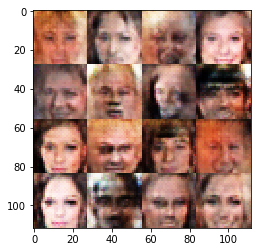

Epoch 1/1... Batch 1110... Generator Loss: 0.8569 Discriminator Loss: 1.1609
Epoch 1/1... Batch 1120... Generator Loss: 0.5716 Discriminator Loss: 1.4247
Epoch 1/1... Batch 1130... Generator Loss: 0.6250 Discriminator Loss: 1.3677
Epoch 1/1... Batch 1140... Generator Loss: 1.1962 Discriminator Loss: 1.5384
Epoch 1/1... Batch 1150... Generator Loss: 1.2110 Discriminator Loss: 1.2809
Epoch 1/1... Batch 1160... Generator Loss: 0.8711 Discriminator Loss: 1.2079
Epoch 1/1... Batch 1170... Generator Loss: 0.8256 Discriminator Loss: 1.2985
Epoch 1/1... Batch 1180... Generator Loss: 1.0301 Discriminator Loss: 1.3682
Epoch 1/1... Batch 1190... Generator Loss: 0.9763 Discriminator Loss: 1.1747
Epoch 1/1... Batch 1200... Generator Loss: 0.7682 Discriminator Loss: 1.2473


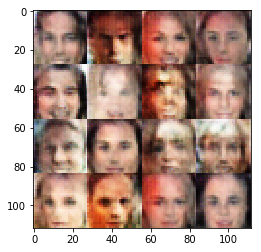

Epoch 1/1... Batch 1210... Generator Loss: 0.8452 Discriminator Loss: 1.2652
Epoch 1/1... Batch 1220... Generator Loss: 0.6041 Discriminator Loss: 1.4673
Epoch 1/1... Batch 1230... Generator Loss: 0.7708 Discriminator Loss: 1.2360
Epoch 1/1... Batch 1240... Generator Loss: 0.5007 Discriminator Loss: 1.4757
Epoch 1/1... Batch 1250... Generator Loss: 1.0186 Discriminator Loss: 1.2294
Epoch 1/1... Batch 1260... Generator Loss: 0.7823 Discriminator Loss: 1.3387
Epoch 1/1... Batch 1270... Generator Loss: 0.8698 Discriminator Loss: 1.2458
Epoch 1/1... Batch 1280... Generator Loss: 0.7140 Discriminator Loss: 1.3027
Epoch 1/1... Batch 1290... Generator Loss: 0.8642 Discriminator Loss: 1.2292
Epoch 1/1... Batch 1300... Generator Loss: 0.6215 Discriminator Loss: 1.4322


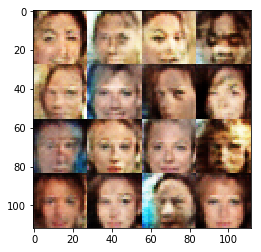

Epoch 1/1... Batch 1310... Generator Loss: 0.7849 Discriminator Loss: 1.3180
Epoch 1/1... Batch 1320... Generator Loss: 0.6656 Discriminator Loss: 1.3074
Epoch 1/1... Batch 1330... Generator Loss: 0.8359 Discriminator Loss: 1.2363
Epoch 1/1... Batch 1340... Generator Loss: 0.6861 Discriminator Loss: 1.3331
Epoch 1/1... Batch 1350... Generator Loss: 0.7726 Discriminator Loss: 1.2989
Epoch 1/1... Batch 1360... Generator Loss: 0.8965 Discriminator Loss: 1.2219
Epoch 1/1... Batch 1370... Generator Loss: 0.8249 Discriminator Loss: 1.3361
Epoch 1/1... Batch 1380... Generator Loss: 0.6912 Discriminator Loss: 1.3525
Epoch 1/1... Batch 1390... Generator Loss: 1.5074 Discriminator Loss: 1.2291
Epoch 1/1... Batch 1400... Generator Loss: 0.8377 Discriminator Loss: 1.3373


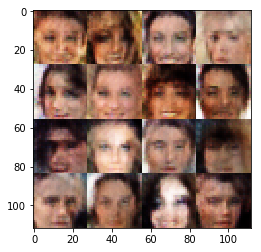

Epoch 1/1... Batch 1410... Generator Loss: 0.6333 Discriminator Loss: 1.3234
Epoch 1/1... Batch 1420... Generator Loss: 0.9644 Discriminator Loss: 1.3173
Epoch 1/1... Batch 1430... Generator Loss: 0.7901 Discriminator Loss: 1.2720
Epoch 1/1... Batch 1440... Generator Loss: 0.4862 Discriminator Loss: 1.4946
Epoch 1/1... Batch 1450... Generator Loss: 0.6786 Discriminator Loss: 1.3591
Epoch 1/1... Batch 1460... Generator Loss: 0.6327 Discriminator Loss: 1.3937
Epoch 1/1... Batch 1470... Generator Loss: 0.7881 Discriminator Loss: 1.2643
Epoch 1/1... Batch 1480... Generator Loss: 0.6101 Discriminator Loss: 1.3715
Epoch 1/1... Batch 1490... Generator Loss: 0.6417 Discriminator Loss: 1.4017
Epoch 1/1... Batch 1500... Generator Loss: 0.6969 Discriminator Loss: 1.2435


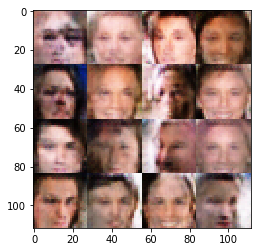

Epoch 1/1... Batch 1510... Generator Loss: 0.7719 Discriminator Loss: 1.2637
Epoch 1/1... Batch 1520... Generator Loss: 0.5504 Discriminator Loss: 1.3734
Epoch 1/1... Batch 1530... Generator Loss: 1.1296 Discriminator Loss: 1.1694
Epoch 1/1... Batch 1540... Generator Loss: 1.0100 Discriminator Loss: 1.1834
Epoch 1/1... Batch 1550... Generator Loss: 1.1434 Discriminator Loss: 1.1922
Epoch 1/1... Batch 1560... Generator Loss: 1.0282 Discriminator Loss: 1.1514
Epoch 1/1... Batch 1570... Generator Loss: 1.0588 Discriminator Loss: 1.3014
Epoch 1/1... Batch 1580... Generator Loss: 0.7451 Discriminator Loss: 1.2356
Epoch 1/1... Batch 1590... Generator Loss: 0.8102 Discriminator Loss: 1.2555
Epoch 1/1... Batch 1600... Generator Loss: 0.7051 Discriminator Loss: 1.3922


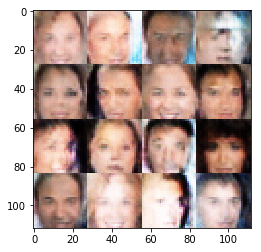

Epoch 1/1... Batch 1610... Generator Loss: 0.6794 Discriminator Loss: 1.3821
Epoch 1/1... Batch 1620... Generator Loss: 0.8980 Discriminator Loss: 1.2124
Epoch 1/1... Batch 1630... Generator Loss: 0.7403 Discriminator Loss: 1.3725
Epoch 1/1... Batch 1640... Generator Loss: 0.5912 Discriminator Loss: 1.4691
Epoch 1/1... Batch 1650... Generator Loss: 0.6616 Discriminator Loss: 1.3331
Epoch 1/1... Batch 1660... Generator Loss: 0.5783 Discriminator Loss: 1.4389
Epoch 1/1... Batch 1670... Generator Loss: 0.7377 Discriminator Loss: 1.4134
Epoch 1/1... Batch 1680... Generator Loss: 0.6072 Discriminator Loss: 1.4310
Epoch 1/1... Batch 1690... Generator Loss: 0.6153 Discriminator Loss: 1.2803
Epoch 1/1... Batch 1700... Generator Loss: 0.9966 Discriminator Loss: 1.1822


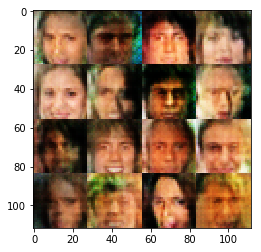

Epoch 1/1... Batch 1710... Generator Loss: 0.7181 Discriminator Loss: 1.2732
Epoch 1/1... Batch 1720... Generator Loss: 0.6677 Discriminator Loss: 1.3216
Epoch 1/1... Batch 1730... Generator Loss: 1.0700 Discriminator Loss: 1.1947
Epoch 1/1... Batch 1740... Generator Loss: 0.6782 Discriminator Loss: 1.4475
Epoch 1/1... Batch 1750... Generator Loss: 0.4843 Discriminator Loss: 1.4414
Epoch 1/1... Batch 1760... Generator Loss: 1.1560 Discriminator Loss: 1.1906
Epoch 1/1... Batch 1770... Generator Loss: 0.7848 Discriminator Loss: 1.1786
Epoch 1/1... Batch 1780... Generator Loss: 0.6122 Discriminator Loss: 1.3872
Epoch 1/1... Batch 1790... Generator Loss: 0.8469 Discriminator Loss: 1.2752
Epoch 1/1... Batch 1800... Generator Loss: 0.6125 Discriminator Loss: 1.3729


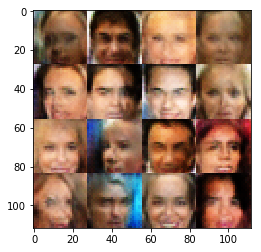

Epoch 1/1... Batch 1810... Generator Loss: 1.3235 Discriminator Loss: 1.2154
Epoch 1/1... Batch 1820... Generator Loss: 0.6932 Discriminator Loss: 1.2619
Epoch 1/1... Batch 1830... Generator Loss: 0.9984 Discriminator Loss: 1.2277
Epoch 1/1... Batch 1840... Generator Loss: 0.8840 Discriminator Loss: 1.1980
Epoch 1/1... Batch 1850... Generator Loss: 0.8899 Discriminator Loss: 1.4565
Epoch 1/1... Batch 1860... Generator Loss: 0.8870 Discriminator Loss: 1.1821
Epoch 1/1... Batch 1870... Generator Loss: 0.5259 Discriminator Loss: 1.4456
Epoch 1/1... Batch 1880... Generator Loss: 0.7151 Discriminator Loss: 1.2356
Epoch 1/1... Batch 1890... Generator Loss: 0.8537 Discriminator Loss: 1.2753
Epoch 1/1... Batch 1900... Generator Loss: 0.5412 Discriminator Loss: 1.4321


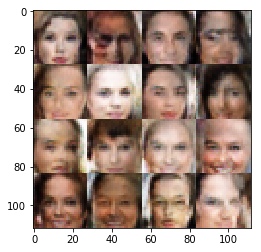

Epoch 1/1... Batch 1910... Generator Loss: 1.0650 Discriminator Loss: 1.1030
Epoch 1/1... Batch 1920... Generator Loss: 0.6590 Discriminator Loss: 1.3287
Epoch 1/1... Batch 1930... Generator Loss: 0.7203 Discriminator Loss: 1.3140
Epoch 1/1... Batch 1940... Generator Loss: 0.8070 Discriminator Loss: 1.3817
Epoch 1/1... Batch 1950... Generator Loss: 0.5836 Discriminator Loss: 1.3691
Epoch 1/1... Batch 1960... Generator Loss: 0.6711 Discriminator Loss: 1.3548
Epoch 1/1... Batch 1970... Generator Loss: 0.8750 Discriminator Loss: 1.2440
Epoch 1/1... Batch 1980... Generator Loss: 0.7067 Discriminator Loss: 1.4840
Epoch 1/1... Batch 1990... Generator Loss: 0.5729 Discriminator Loss: 1.4186
Epoch 1/1... Batch 2000... Generator Loss: 0.9633 Discriminator Loss: 1.1768


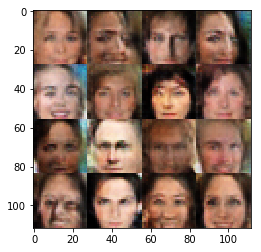

Epoch 1/1... Batch 2010... Generator Loss: 0.5689 Discriminator Loss: 1.4588
Epoch 1/1... Batch 2020... Generator Loss: 0.5560 Discriminator Loss: 1.4523
Epoch 1/1... Batch 2030... Generator Loss: 0.9514 Discriminator Loss: 1.2657
Epoch 1/1... Batch 2040... Generator Loss: 0.6323 Discriminator Loss: 1.3526
Epoch 1/1... Batch 2050... Generator Loss: 1.0752 Discriminator Loss: 1.3083
Epoch 1/1... Batch 2060... Generator Loss: 0.6239 Discriminator Loss: 1.3670
Epoch 1/1... Batch 2070... Generator Loss: 0.7830 Discriminator Loss: 1.2281
Epoch 1/1... Batch 2080... Generator Loss: 1.0399 Discriminator Loss: 1.2986
Epoch 1/1... Batch 2090... Generator Loss: 0.6573 Discriminator Loss: 1.4492
Epoch 1/1... Batch 2100... Generator Loss: 0.6533 Discriminator Loss: 1.3351


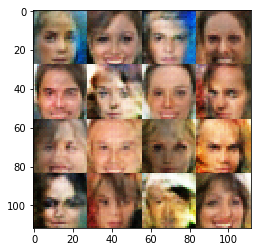

Epoch 1/1... Batch 2110... Generator Loss: 0.8950 Discriminator Loss: 1.2588
Epoch 1/1... Batch 2120... Generator Loss: 0.9718 Discriminator Loss: 1.3386
Epoch 1/1... Batch 2130... Generator Loss: 0.7971 Discriminator Loss: 1.2723
Epoch 1/1... Batch 2140... Generator Loss: 0.8762 Discriminator Loss: 1.3164
Epoch 1/1... Batch 2150... Generator Loss: 0.7743 Discriminator Loss: 1.3480
Epoch 1/1... Batch 2160... Generator Loss: 0.6366 Discriminator Loss: 1.3421
Epoch 1/1... Batch 2170... Generator Loss: 0.8411 Discriminator Loss: 1.2976
Epoch 1/1... Batch 2180... Generator Loss: 0.5605 Discriminator Loss: 1.4580
Epoch 1/1... Batch 2190... Generator Loss: 0.5788 Discriminator Loss: 1.3871
Epoch 1/1... Batch 2200... Generator Loss: 0.5630 Discriminator Loss: 1.3986


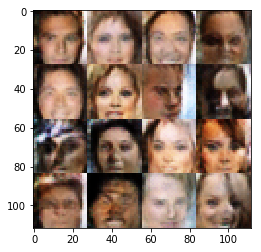

Epoch 1/1... Batch 2210... Generator Loss: 0.7239 Discriminator Loss: 1.3989
Epoch 1/1... Batch 2220... Generator Loss: 0.6277 Discriminator Loss: 1.3955
Epoch 1/1... Batch 2230... Generator Loss: 0.9280 Discriminator Loss: 1.3233
Epoch 1/1... Batch 2240... Generator Loss: 0.7941 Discriminator Loss: 1.3625
Epoch 1/1... Batch 2250... Generator Loss: 0.9193 Discriminator Loss: 1.2875
Epoch 1/1... Batch 2260... Generator Loss: 0.9782 Discriminator Loss: 1.1930
Epoch 1/1... Batch 2270... Generator Loss: 0.7826 Discriminator Loss: 1.3192
Epoch 1/1... Batch 2280... Generator Loss: 0.6129 Discriminator Loss: 1.4083
Epoch 1/1... Batch 2290... Generator Loss: 0.9771 Discriminator Loss: 1.2432
Epoch 1/1... Batch 2300... Generator Loss: 1.0150 Discriminator Loss: 1.3670


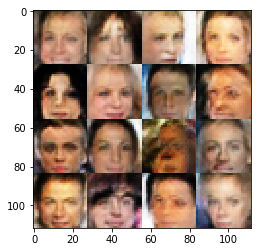

Epoch 1/1... Batch 2310... Generator Loss: 0.8481 Discriminator Loss: 1.3566
Epoch 1/1... Batch 2320... Generator Loss: 0.7317 Discriminator Loss: 1.3018
Epoch 1/1... Batch 2330... Generator Loss: 0.9282 Discriminator Loss: 1.2182
Epoch 1/1... Batch 2340... Generator Loss: 0.6336 Discriminator Loss: 1.3077
Epoch 1/1... Batch 2350... Generator Loss: 0.6092 Discriminator Loss: 1.3998
Epoch 1/1... Batch 2360... Generator Loss: 0.6822 Discriminator Loss: 1.2751
Epoch 1/1... Batch 2370... Generator Loss: 0.7332 Discriminator Loss: 1.3412
Epoch 1/1... Batch 2380... Generator Loss: 0.8324 Discriminator Loss: 1.2790
Epoch 1/1... Batch 2390... Generator Loss: 0.6119 Discriminator Loss: 1.3339
Epoch 1/1... Batch 2400... Generator Loss: 0.5166 Discriminator Loss: 1.4470


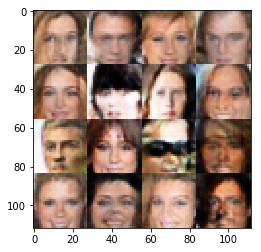

Epoch 1/1... Batch 2410... Generator Loss: 0.6351 Discriminator Loss: 1.3442
Epoch 1/1... Batch 2420... Generator Loss: 0.7965 Discriminator Loss: 1.3157
Epoch 1/1... Batch 2430... Generator Loss: 0.9300 Discriminator Loss: 1.2395
Epoch 1/1... Batch 2440... Generator Loss: 0.6349 Discriminator Loss: 1.4288
Epoch 1/1... Batch 2450... Generator Loss: 0.8268 Discriminator Loss: 1.3324
Epoch 1/1... Batch 2460... Generator Loss: 0.6962 Discriminator Loss: 1.3144
Epoch 1/1... Batch 2470... Generator Loss: 0.6371 Discriminator Loss: 1.4334
Epoch 1/1... Batch 2480... Generator Loss: 0.9827 Discriminator Loss: 1.2477
Epoch 1/1... Batch 2490... Generator Loss: 0.7415 Discriminator Loss: 1.4234
Epoch 1/1... Batch 2500... Generator Loss: 0.5507 Discriminator Loss: 1.4355


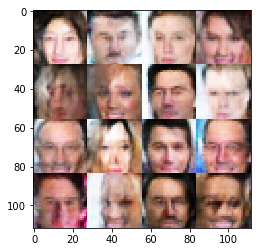

Epoch 1/1... Batch 2510... Generator Loss: 0.7681 Discriminator Loss: 1.3203
Epoch 1/1... Batch 2520... Generator Loss: 0.6438 Discriminator Loss: 1.3403
Epoch 1/1... Batch 2530... Generator Loss: 0.6696 Discriminator Loss: 1.3163
Epoch 1/1... Batch 2540... Generator Loss: 0.8444 Discriminator Loss: 1.2429
Epoch 1/1... Batch 2550... Generator Loss: 0.7611 Discriminator Loss: 1.3873
Epoch 1/1... Batch 2560... Generator Loss: 1.1362 Discriminator Loss: 1.2034
Epoch 1/1... Batch 2570... Generator Loss: 0.9236 Discriminator Loss: 1.4614
Epoch 1/1... Batch 2580... Generator Loss: 0.7677 Discriminator Loss: 1.3069
Epoch 1/1... Batch 2590... Generator Loss: 0.8105 Discriminator Loss: 1.3625
Epoch 1/1... Batch 2600... Generator Loss: 0.7428 Discriminator Loss: 1.3227


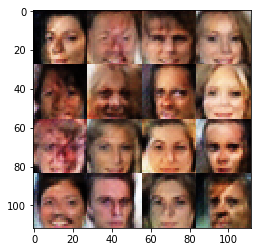

Epoch 1/1... Batch 2610... Generator Loss: 0.8005 Discriminator Loss: 1.3466
Epoch 1/1... Batch 2620... Generator Loss: 0.6369 Discriminator Loss: 1.3894
Epoch 1/1... Batch 2630... Generator Loss: 0.6083 Discriminator Loss: 1.3334
Epoch 1/1... Batch 2640... Generator Loss: 0.7585 Discriminator Loss: 1.2211
Epoch 1/1... Batch 2650... Generator Loss: 0.7837 Discriminator Loss: 1.2155
Epoch 1/1... Batch 2660... Generator Loss: 0.8204 Discriminator Loss: 1.2713
Epoch 1/1... Batch 2670... Generator Loss: 0.8981 Discriminator Loss: 1.1795
Epoch 1/1... Batch 2680... Generator Loss: 0.8327 Discriminator Loss: 1.2947
Epoch 1/1... Batch 2690... Generator Loss: 0.5270 Discriminator Loss: 1.4751
Epoch 1/1... Batch 2700... Generator Loss: 0.7065 Discriminator Loss: 1.3177


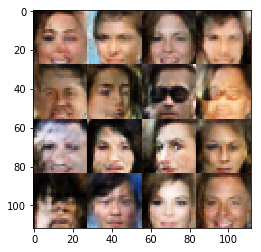

Epoch 1/1... Batch 2710... Generator Loss: 0.7555 Discriminator Loss: 1.3714
Epoch 1/1... Batch 2720... Generator Loss: 0.9851 Discriminator Loss: 1.2682
Epoch 1/1... Batch 2730... Generator Loss: 0.4881 Discriminator Loss: 1.4413
Epoch 1/1... Batch 2740... Generator Loss: 0.6313 Discriminator Loss: 1.3782
Epoch 1/1... Batch 2750... Generator Loss: 0.7301 Discriminator Loss: 1.2824
Epoch 1/1... Batch 2760... Generator Loss: 1.1245 Discriminator Loss: 1.2951
Epoch 1/1... Batch 2770... Generator Loss: 0.7421 Discriminator Loss: 1.3582
Epoch 1/1... Batch 2780... Generator Loss: 0.5621 Discriminator Loss: 1.3961
Epoch 1/1... Batch 2790... Generator Loss: 0.5245 Discriminator Loss: 1.4147
Epoch 1/1... Batch 2800... Generator Loss: 0.9304 Discriminator Loss: 1.1494


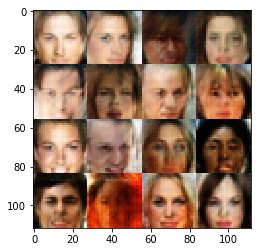

Epoch 1/1... Batch 2810... Generator Loss: 0.6347 Discriminator Loss: 1.3098
Epoch 1/1... Batch 2820... Generator Loss: 0.8009 Discriminator Loss: 1.2670
Epoch 1/1... Batch 2830... Generator Loss: 0.6636 Discriminator Loss: 1.3593
Epoch 1/1... Batch 2840... Generator Loss: 0.5883 Discriminator Loss: 1.4161
Epoch 1/1... Batch 2850... Generator Loss: 0.6720 Discriminator Loss: 1.2651
Epoch 1/1... Batch 2860... Generator Loss: 0.7368 Discriminator Loss: 1.3464
Epoch 1/1... Batch 2870... Generator Loss: 0.6731 Discriminator Loss: 1.3195
Epoch 1/1... Batch 2880... Generator Loss: 0.7291 Discriminator Loss: 1.2059
Epoch 1/1... Batch 2890... Generator Loss: 0.8767 Discriminator Loss: 1.1955
Epoch 1/1... Batch 2900... Generator Loss: 0.7075 Discriminator Loss: 1.3086


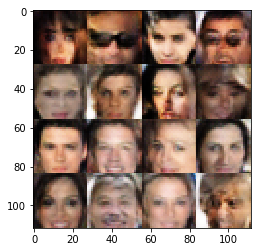

Epoch 1/1... Batch 2910... Generator Loss: 0.6553 Discriminator Loss: 1.3019
Epoch 1/1... Batch 2920... Generator Loss: 0.7416 Discriminator Loss: 1.2867
Epoch 1/1... Batch 2930... Generator Loss: 0.8023 Discriminator Loss: 1.2222
Epoch 1/1... Batch 2940... Generator Loss: 0.9120 Discriminator Loss: 1.4883
Epoch 1/1... Batch 2950... Generator Loss: 0.5634 Discriminator Loss: 1.4253
Epoch 1/1... Batch 2960... Generator Loss: 0.5768 Discriminator Loss: 1.4417
Epoch 1/1... Batch 2970... Generator Loss: 1.1043 Discriminator Loss: 1.2859
Epoch 1/1... Batch 2980... Generator Loss: 0.5784 Discriminator Loss: 1.3741
Epoch 1/1... Batch 2990... Generator Loss: 0.9842 Discriminator Loss: 1.2288
Epoch 1/1... Batch 3000... Generator Loss: 0.5695 Discriminator Loss: 1.3845


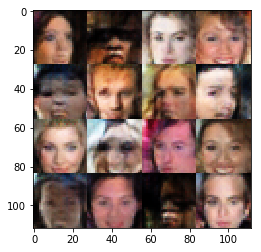

Epoch 1/1... Batch 3010... Generator Loss: 0.8305 Discriminator Loss: 1.2227
Epoch 1/1... Batch 3020... Generator Loss: 0.5628 Discriminator Loss: 1.3583
Epoch 1/1... Batch 3030... Generator Loss: 0.7162 Discriminator Loss: 1.3040
Epoch 1/1... Batch 3040... Generator Loss: 0.6077 Discriminator Loss: 1.4503
Epoch 1/1... Batch 3050... Generator Loss: 1.0031 Discriminator Loss: 1.2852
Epoch 1/1... Batch 3060... Generator Loss: 0.7551 Discriminator Loss: 1.2919
Epoch 1/1... Batch 3070... Generator Loss: 0.6479 Discriminator Loss: 1.3070
Epoch 1/1... Batch 3080... Generator Loss: 1.2478 Discriminator Loss: 1.2108
Epoch 1/1... Batch 3090... Generator Loss: 0.6352 Discriminator Loss: 1.3170
Epoch 1/1... Batch 3100... Generator Loss: 0.7152 Discriminator Loss: 1.3111


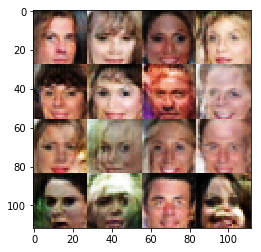

Epoch 1/1... Batch 3110... Generator Loss: 0.4570 Discriminator Loss: 1.5479
Epoch 1/1... Batch 3120... Generator Loss: 0.5452 Discriminator Loss: 1.4665
Epoch 1/1... Batch 3130... Generator Loss: 1.0223 Discriminator Loss: 1.3394
Epoch 1/1... Batch 3140... Generator Loss: 0.8557 Discriminator Loss: 1.3178
Epoch 1/1... Batch 3150... Generator Loss: 0.6007 Discriminator Loss: 1.4407
Epoch 1/1... Batch 3160... Generator Loss: 0.5677 Discriminator Loss: 1.4045


In [16]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.